# imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

C:\Users\Risha H M\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Risha H M\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\Risha H M\AppData\Roaming\Python\Python313\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.pr

# Dataset paths

In [2]:
train_dir =  r"C:\Users\Risha H M\AI_Crop_System\crop_disease_detection\data\split\train"
val_dir = r"C:\Users\Risha H M\AI_Crop_System\crop_disease_detection\data\split\val"
test_dir = r"C:\Users\Risha H M\AI_Crop_System\crop_disease_detection\data\split\test"

# Image setting

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


# Data augmentation

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
num_classes = train_generator.num_classes
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=train_generator.class_indices.keys() 
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=train_generator.class_indices.keys() 
)

Found 1855 images belonging to 3 classes.
Found 370 images belonging to 3 classes.
Found 250 images belonging to 3 classes.


In [5]:
print(train_generator.class_indices)

{'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'PlantVillage': 2}


# MobileNetV2 base model

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
print("Class indices:", train_generator.class_indices)

Class indices: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'PlantVillage': 2}


# Compile model

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

C:\Users\Risha H M\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7617 - loss: 0.5469 - val_accuracy: 0.8919 - val_loss: 0.2569
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9272 - loss: 0.1996 - val_accuracy: 0.9189 - val_loss: 0.2029
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9515 - loss: 0.1495 - val_accuracy: 0.9216 - val_loss: 0.1714
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9472 - loss: 0.1335 - val_accuracy: 0.9324 - val_loss: 0.1559
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9606 - loss: 0.1181 - val_accuracy: 0.9378 - val_loss: 0.1411


In [10]:
#  Unfreeze the top layers of MobileNetV2 for fine-tuning
base_model.trainable = True

# Optionally, freeze most layers except last 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compile again with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 5
total_epochs = 5 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1
)


Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7466 - loss: 0.6187 - val_accuracy: 0.9081 - val_loss: 0.2293
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9385 - loss: 0.1471 - val_accuracy: 0.9135 - val_loss: 0.2159
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9590 - loss: 0.0992 - val_accuracy: 0.9189 - val_loss: 0.2171
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9752 - loss: 0.0704 - val_accuracy: 0.9081 - val_loss: 0.2584
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9763 - loss: 0.0683 - val_accuracy: 0.9162 - val_loss: 0.2477


# Save model

In [14]:
model.save("crop_disease_model.h5")
print(" Model saved as crop_disease_model.h5")

 Model saved as crop_disease_model.h5


# Plot accuracy

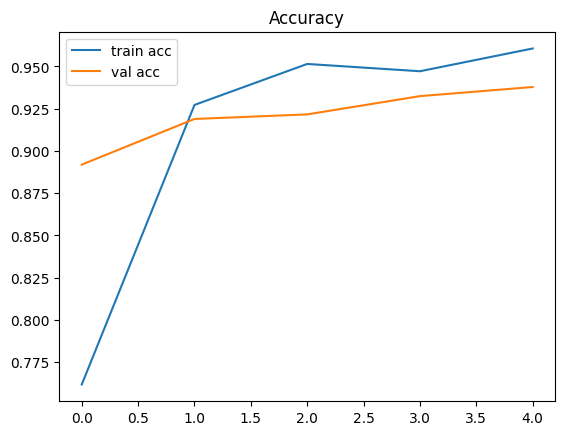

In [15]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Evaluate on test data

In [16]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - accuracy: 0.9480 - loss: 0.1325
Test Accuracy: 94.80%
